You're an analyst at Crankshaft List. Hundreds of free advertisements for vehicles are published on your site every day. You need to study data collected over the last few years and determine which factors influence the price of a vehicle.

Dataset = https://code.s3.yandex.net/datasets/vehicles_us.csv

## Initialization

In [39]:
# Loading all the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from scipy import stats 
import matplotlib_inline.backend_inline

### These lines will make the graphs much crisper

# if isinstance('svg', str):
#    ipython_format = ['svg']
#    matplotlib_inline.backend_inline.set_matplotlib_formats(*ipython_format)



### Loading the data

In [40]:
# Load the data file into raw_data df.

try:
  raw_data = pd.read_csv("/content/sample_data/vehicles_us.csv", )
except: 
  raw_data = pd.read_csv("/datasets/vehicles_us.csv", )

The dataset contains the following fields:
- `price`
- `model_year`
- `model`
- `condition`
- `cylinders`
- `fuel` — gas, diesel, etc.
- `odometer` — the vehicle's mileage when the ad was published
- `transmission`
- `paint_color`
- `is_4wd` — whether the vehicle has 4-wheel drive (Boolean type)
- `date_posted` — the date the ad was published
- `days_listed` — from publication to removal


In [41]:
# Summary information about the DataFrame
raw_data.info()


Some initial thoughts after calling info() method:

1.   Column11: date_posted is object. We expect to see here datetime.
3.   Multiple instances of missing vals in is_4wd, paint_color, odometer, cylinders, model_year column. 
4.   Column1: model_year is in float, which is strange. We expect to see here integer or datetime. 


Let's call describe()

In [42]:
raw_data.describe()

### By calling the describe() we learn the following: 

1. While the price's Q2 mark is 9000$ (meaning half of the overall prices are 9000 or bellow) while the max price is 3.75m. It tells us that we will see an extremely long upper tail in our price chart. 

2. We also notice a 1 dollar price tags in the price's min. Meaning that in some instances people chose to deliberatly post the lowest price allowed on our website - one dollar. This is often done to optimize the search by price. These cars are obviously not sold for 1$. 

3. Inspecting the model_year column of describe() we also see a min model year of 1908. If we had a specialized website for an antique cars, including these instances would be appropriate, but we should be cautios including these instances in our EDA where they will compete with the modern cars. People don't buy a 1908 car to drive to work. 

4.  Odometer max (990000 km) looks somewhat suspecious. We will check this number by calculating the yearly avr of this car. Maybe there's an extra zero here. 




In [43]:
# Sample of data
raw_data.head(10)


As already noted above, there are multiple columns with wrong format and multiple instances of missing vals. Using the info method reveals that we have missing vals in 5 of 13 columns.
Our other concern, not yet explored, is the discriptions in the categorical columns. Are they unified? Are there misspelings? Difference in notations? Let's briefly explore this by calling value_counts() 

In [44]:
#Let's get rid of the numerical columns and the model column.

list_of_categories = raw_data.columns.drop(["price", "model_year", "odometer", "date_posted", "days_listed", "model"])

#Let's call value_counts on the remaining categories:
for cat in list_of_categories:
  print( cat.upper() )
  print("*****************")
  print("* There are", len(raw_data[cat].unique()), "unique categories in", cat, "column:")
  print("*", raw_data[cat].isna().sum(), "values are missing")
  print(raw_data[cat].value_counts())
  print("****************")
  print(" ")

The is_4wd column contains either 1.0 or Nans. For now we will leave it as it is, but this is something we should be aware of. 

### Conclusions and further steps

Our dataset, imported as raw data is not ready for EDA. WE have 5 columns wt missing values, multiple instances wt wrong formats (str instead datetime, for example), some very unlikely high and low instances (outliers). These and other problems (antique cars, for instance) can distort our EDA. 

We will start to prepare our dataset by first treating the missing values columns one by one. 

# Treating missing values 

### MODEL YEAR AND CYLINDERS 

The missing vals in the model_year and cylinder columns can be explained by the fact that many car owners, especially those that own second and third hand cars, don't really know or (never bothered to) remember their car's model year and num of cylinders. 

Our solution to filling Nans in both of these columns, would be to asign the missing model_year based on the same model parameters from other, fully filled-in instances. As a guide we will use the parameters: model, fuel, transmission, type. If other fully filled-in instances will match our problematic listing, then and only then we will asign the missing year.


In [45]:
# First let's see how many Nans we have in model_year column and cylinders column:
print("We have", raw_data.cylinders.isna().sum(), "missing vals in cylinders column and", raw_data.model_year.isna().sum(), "in model year column")# 
print(" ")

# Now let's asign the new values to these two columns:

for col in ["model_year", "cylinders"]:

  raw_data[col] = raw_data.groupby(["model", "transmission", "type", "fuel"])[col].transform(lambda x: x.fillna(x.mode().max()))

# Let's check the Nans again:

print("Now we have", raw_data.cylinders.isna().sum(), "missing vals in cylinders column and", raw_data.model_year.isna().sum(), "in model year column")# 



Amazing. with a line of code we eliminated 99% of the Nans by asigning the vals from the same vehicles, based on "model", "transmission", "type" and "fuel" columns.

Next, the PAINT_COLOR column:

In [46]:
print("We have", raw_data.paint_color.isna().sum(), "nans in our paint_color")
print(" ")
# Let's assign "not specified" instead of Nans

raw_data.loc[raw_data.paint_color.isna(), "paint_color"]  = "not specified"

# Let's check the Nans again:

print("Now we have", raw_data.paint_color.isna().sum(), "nans in our paint_color")

THE ODOMETER NANS

Unlike model year and cylinders, the odometer values can not be correctly estimated. Therefore we decided to remove the missing values from the odometer column. 

In [47]:
print("We have", raw_data.odometer.isna().sum(), "nans in our odometer column")
print(" ")
# Let's assign "not specified" instead of Nans

raw_data.dropna(subset = ["odometer"], inplace=True)

# Let's check the Nans again:

print("Now we have",  raw_data.odometer.isna().sum(), "nans in our odometer column")

## Fixing the data types

Are cylinders categories should be floats or ints? 
Let's call value_count to see what's going on there:

In [48]:
raw_data.cylinders.value_counts()

Seems like all the vals are ints already. Let's leave the remaining Nans in cylinders as they are. We don't want to asign it a number. 



Next. The is_4wd column: seems like there's not much info in this not so boolean column. It contains only value ona and Nans...

In [49]:
print(raw_data.is_4wd.value_counts())
print("**************************")
print("There are", raw_data.is_4wd.isna().sum(), "Nans is the is_4wd column")

From the exersice description we know that all the missing values are False. Therefore let's asign Nans wt zeros:

In [50]:
# Replacing Nans with 0
raw_data.is_4wd.fillna(0, inplace = True)

print("We have", raw_data.is_4wd.isna().sum(), " Nans now")

In [51]:
raw_data.info()

## Enrich data

Next, we will enrich our data with a few new columns that will assist us later on with our analisys. Now is the time to fix the date_posted and model_year columns. 


In [52]:
# First let's convert and tweak our datetimes a little, we need to get the dates for our further calculation:
raw_data.date_posted = pd.to_datetime(raw_data.date_posted, format='%Y-%m-%d')
raw_data.model_year = pd.to_datetime(raw_data.model_year, format= "%Y")

# Now let's create a column:
raw_data["cars_age"] = round((raw_data.date_posted - raw_data.model_year) / np.timedelta64(1, 'Y'), 2)


In [53]:
# Let's check it:

raw_data["cars_age"]

In [54]:
# The vehicle's average mileage per year
raw_data["avr_mil"] = round(raw_data.odometer / raw_data["cars_age"], 2)

raw_data["avr_mil"].head(5)

Now let's reasign the condition column with numbers:

In [55]:
# Condition values in numbers 0 to 5:

raw_data.condition.replace({"new": 5, "like new":4, "excellent": 3, "good" : 2, "fair": 1, "salvage" : 0}, inplace = True)


In [56]:
# Let's also create a column with clean years, just in case we'll need it. Only 4 digits.

raw_data["yearly"] = raw_data.model_year.dt.year


Before we start our analysis, a little house keeping: let's fix the 1 dollar car instances, as these are not the real price tags. Let's see the top 10 minimum price tags, to check that we don't have 2 and 3 dollar cars...

In [57]:
raw_data.sort_values("price", ascending = True).head(10)

That... doesn't help us, since there are too many 1 dollar cars. Let's try a different approach:

In [58]:
a = raw_data.price.unique()
sorted(a)[:20]

Well, looks like we have tons of very cheap cars. Let's calculate how many cars are bellow 200$

In [59]:
raw_data[raw_data.price<200]["price"].count()

We know from our experience with car dealership that any price tag bellow 200 USD is a fake price that is used for search optimization but some people are ready to buy 200$ cars to repair other cars. So the 200 USD is a normal price range for this purpose. 

We also assume that all the cars older than 40 y.o. are collectibles. These antique listings deserve a dataset of their own and should not compete with the modern models. We define an antique car as a car that is 40 years and older. In our current EDA, we will concentrate only on the cars that were produced in the last 40 years. It will provide a more stable, meaningfull analysis of our data. People buy a 2008 car to get to work whereas a 1954 car can be seen as an investment or a collection item and therefore these two listing should not compete with each other. 

We will sift our data on these two criterias: 


In [60]:
clean_data = raw_data.query("cars_age < 40 and price > 200" )

# Let's check:

print("The min price in our data is", min(clean_data.price), "and the oldest car model is from", min(clean_data.yearly) )
print("************************************************************************")
c = clean_data.yearly.unique()
sorted(c)[:10]


Great. We deal only with 1979+ models! 

## Check clean data

In [61]:
# General/summary information about the DataFrame

clean_data.describe()

Checking the new data again we notice a few new problems:

1. negative vals in car's_age 
2. negative vals in avr_mil
3. inf vals in avr_mil

Before adressing these issues let's check some more:

In [62]:
clean_data.info()

The formats look ok...

In [63]:
# A sample of data
clean_data.head(5)


The overall looks ok too. Let's start studying the core parameters and fix the remaining 3 issues as we go...

## Study core parameters
The parameters are
- Price
- The vehicle's age when the ad was placed
- Mileage
- Number of cylinders
- Condition

Before we fix our data, let's display our core parameters in a user friendly chart, with normalized datas: 

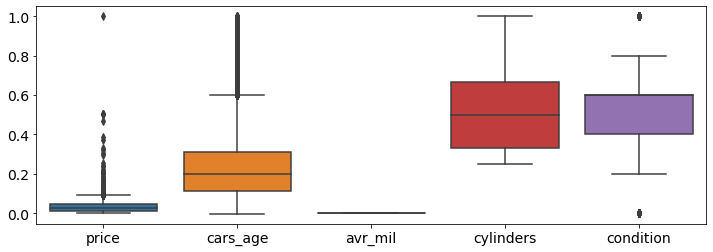

In [64]:
# Let's create a normalized df

normed_df = pd.DataFrame()
list_of_columns = ["price", "cars_age", "avr_mil", "cylinders", "condition"]

for col in list_of_columns:
  normed_df[col] = clean_data[col] / max(clean_data[col])

    
fig,ax = plt.subplots(1,figsize=(12,4))
ax = sns.boxplot(data=normed_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0, )
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.show()


Hmmm. For some mysterious reason it didn't work for the AVR_MIL column. Let's check why: since all we do to "compress" the vals between 0 and 1 is to divide the val by the max val, the only place where it could go wrong is in the max val part. Let's call it:


In [65]:
max(clean_data.avr_mil)

Aha! so the max of avr_mil (and the odometer, from which we derive the data for the avr_mil) is an infinite number. 

But why? We recall that avr_mil is a column that WE ourselves had created, by deviding the odometer by the years. The inf in the resulted column (avr_mil) means that we devided the odometer by zero years old car (brand new cars). 

To adress this problem let's add 1 to all the cars_age column, so that the zeros become positive numbers.. 

In [66]:
clean_data["cars_age"] = round(clean_data["cars_age"] + 1.0, 2) # Don't mind the error... 

In [ ]:
print("Now the minimum age is", min(clean_data["cars_age"]))

In [68]:
# Let's recalculate the vehicle's average mileage per year
clean_data["avr_mil"] = round(clean_data.odometer / clean_data["cars_age"], 2) # That annoying error again. 


In [69]:
print("Now the maximum avr_mil  is", max(clean_data.avr_mil)) 

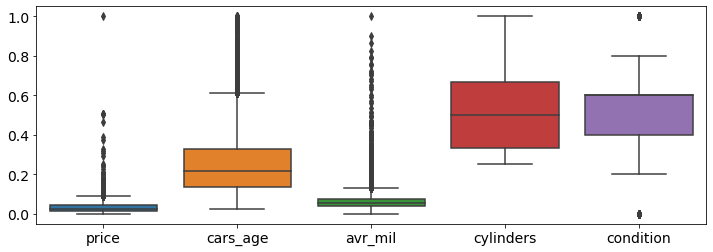

In [70]:
# Let's see if this fixes the problem:

normed_df = pd.DataFrame()
list_of_columns = ["price", "cars_age", "avr_mil", "cylinders", "condition"]

for col in list_of_columns:
  normed_df[col] = clean_data[col] / max(clean_data[col])

    
fig,ax = plt.subplots(1,figsize=(12,4))
ax = sns.boxplot(data=normed_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0, )
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.show()

In [71]:
print("Now the max val in avr_mil is", max(clean_data.avr_mil))

## Much better. There're tons of information in this single chart. 

PRICE chart demonstrates a definitive concentration of prices at the bottom quartile. 75% of ALL the prices are below the 10th of the price of the most expensive car in our list. We come to this conclusion by looking at the level of the Q3 line (75%). More over, the top two cars are SO expensive that even the prices that lay beyond our Q3 line barely reach the 50% of the max price! 

These two cars are obvious outliers. Let's see what are the actual prices:

In [72]:
clean_data.sort_values(by = "price", ascending=False).head(10)

So from the table above, we can clearly see our two outliers, 300K+. There's a significant gap in a price range (that we can see on the graph) between those two listings and the other expensive cars. We will leave these outliers as they are for now, as we continue exploring the other columns:

---

Let's call the plot again:

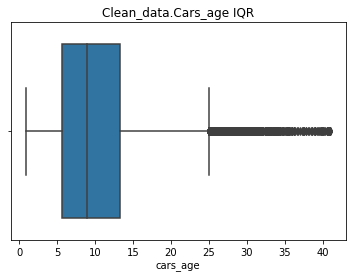

In [73]:
sns.boxplot(x = clean_data.cars_age).set_title("Clean_data.Cars_age IQR")
plt.show()
clean_data.cars_age.describe()

We can see that the Q3 (75%) of car's_age listings are 13 years old or younger, while the vast majority is concentrated around 9 years of age.  Let's plot the distribution of cars' ages\:

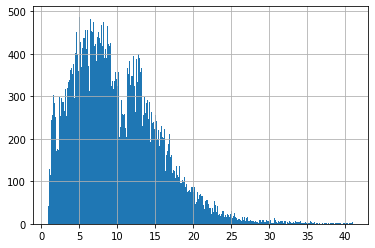

In [74]:
clean_data["cars_age"].hist(bins = 300)
plt.show()

<div class="alert alert-warning">
<b>Reviewer's comment v1:</b>
    
Adding titles to your graphs is important for providing context for the users so they understand what they are looking at. Together with for example legends and axis labels this is important to support unambiguous interpretation of displayed information.

Interesting. We can clearly notice two distinctive peaks in ages: around 5-6 years and another one, around 11-12. 

Let's continue to the next column:

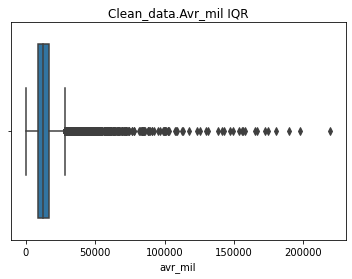

In [75]:
sns.boxplot(x = clean_data.avr_mil).set_title("Clean_data.Avr_mil IQR")
plt.show()
clean_data.avr_mil.describe()

The avr_mil demonstrates an interesting outlier. Did this guy made a round trip across the globe? Let's check it out!

In [76]:
clean_data[clean_data.avr_mil== max(clean_data.avr_mil)]

Hmmm... So the actual odometer shows 373K, and yearly avr nil is 219K... which is very high, but not inprobable. Since we have only 1.7 in the car's age, our avr_mil is VERY VERY high. 

## Study and treat outliers

So far we identified outliers in car's_age, avr_mil and model year, but our data contains also statistical outliers that lay far beyond the Q3 level.  

Therefore we decided to "comb" our data and to include in our analysis only the data that is 96% and lower of the max val. By reducing our data in 4 core columns, we are hoping to achieve a more stable and meaningful dataset.  

In [77]:
list_of_columns = ["cars_age","price", "days_listed", "avr_mil" ]
d = {}
for abc in list_of_columns:
  prc = np.nanpercentile(clean_data[abc], 96)
  upd = {abc : prc}
  d.update(upd)

cleanest = clean_data.query('price < @d.get("price") and cars_age < @d.get("cars_age") and days_listed < @d.get("days_listed") and avr_mil < @d.get("avr_mil")') 

Let's plot these "combed" columns. 

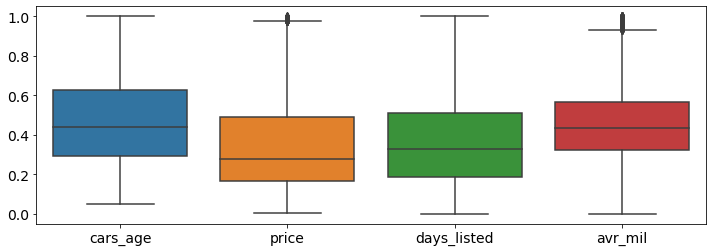

In [78]:
list_of_colum = ["cars_age","price", "days_listed", "avr_mil"]
normed_cleaned_df = pd.DataFrame()

for col in list_of_colum:
  normed_cleaned_df[col] = abs(cleanest[col] / max(cleanest[col]))

    
fig,ax = plt.subplots(1,figsize=(12,4))
ax = sns.boxplot(data= normed_cleaned_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0, )
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.show()



This looks much better. We "pulled out" the medians by eliminating the radical vals. This will allow us to deal with the core of the data and not the dispersed version of it.
In the original, imported dataset we had 51525 instances. Let's see how many rows we dropped on the way: 

In [79]:
print("We dropped", 51525 - len(cleanest), "rows,", round((51525 - len(cleanest))*100 /51525, 2), "% of our data" )

Now we consider our data clean. Our task now is to  determine which factors influence the price of a vehicles.
Let's plot the relationships between the different parameters and try to derive a meaningfull conclutions. 

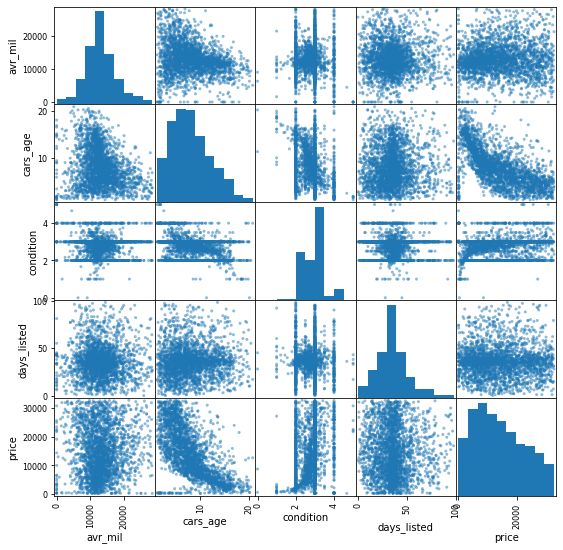

In [80]:

car_stat = cleanest.pivot_table(index=cleanest["price"], values=[ "price", "cars_age", 'avr_mil', 'condition', "days_listed"])

pd.plotting.scatter_matrix(car_stat, figsize=(9, 9))
plt.show()

Indexing our plot on the price value, we notice a very interesting phenomema:
The avr_mil has a negative correlation with cars_age. Meaning that the older cars drove less milles per year. At first it might look a little strange, but let's keep in mind that these are average millage per year, not the overall millage of the vehicle. The modern cars seems to be more reliable that the old ones. This fact can be contributed to the technological developments in the car industry, more efficient engines, tires etc. Plus, the older the car the less it gets used as the family members shift to a newer cars while the older one keeps collecting dust.

Cars_age/price pair shows another example of negative correlation - in general, the older the car, the cheaper it gets. But this correlation is not true for all of the cars - the cars_age/price plot definitevely displays instances of old AND expensive cars. Let's keep in mind that the oldest car in our set is from 1979. We dropped the real antiques. If we would use the antique cars in our data we would see a totally different distribution of price\cars_age relationship.

We also notice a correlation between price and condition. As expected, "salvage" and "good" (0 and 1) have a smaller price value. There's a noticeble "jump" in a price when we shift from "fair" to "good" and above. 

We do not notice a meaningfull corellation between days_listed and price. 

Since we plotted our chart using price as an index, every dot on our plot represents a price instance. It would be interesting to plot the chart using the year of the model as an index. Let's do this:

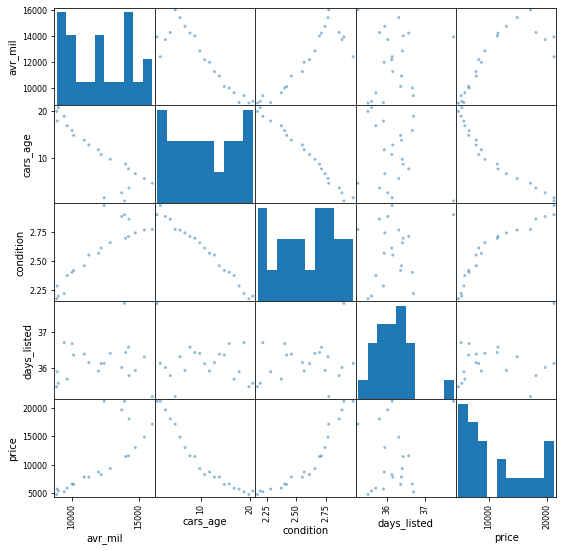

In [81]:
car_stata = cleanest.pivot_table(index=cleanest["model_year"], values=[ "price", "cars_age", 'avr_mil', 'condition', "days_listed"])


pd.plotting.scatter_matrix(car_stata, figsize=(9, 9))
plt.show()

Amazing. The price/car's_age plot is linear... And so many other pairs... Now every dot represents just 1 specific year. We have :

In [82]:
len(cleanest["model_year"].unique())

We have 21 unique years in our data set, and they represented as a 21 dots in each chart. We like this chart more as it allows to inspect the correlations more clearly: Let's look just on the buttom row:

Prices rise as the avr_mil go higher (more modern cars) yet prices drop as the cars get older, prices rise as the condittion gets better while days_listed don't have any effect on the price. 

Let's check the numerical corrs of our table:

In [83]:

print(car_stata.corr())

As stated previously all the parameters are highly correlated with each other exept for days listed. 
Let's compare the current correlation to the unfiltered data. 


In [84]:
print("UNFILTERED DATA")

unfiltered = raw_data.pivot_table(index=raw_data["model_year"], values=[ "price", "cars_age", 'avr_mil', 'condition', "days_listed"])
print(unfiltered.corr())
print(" ")
print("FILTERED DATA")
filtered = cleanest.pivot_table(index=cleanest["model_year"], values=[ "price", "cars_age", 'avr_mil', 'condition', "days_listed"])
print(filtered.corr())


Let's concentrate on the last column - the price. Our sifting and dropping of a data resulted in a higher correlation: 

1. avr_mil/price corr jumped from -0.12 to 0.78, 
2. cars_age/price jumped from 0.38 to -0.95 
3. condition/price from 0.46 to 0.92

while days listed/price raised from 0.02 to 0.24

He have "sharpened" our data!



## Ads lifetime

Now let's look closer at the ads lifetime:


In [85]:
print("Days listed mean is", round(cleanest.days_listed.describe()[1], 2), "days and the median is",cleanest.days_listed.describe()[5]) 

Calling the describe() on days_listed reveals an interesting fact:


In [86]:

print("CLEAN DATA")
print(cleanest.days_listed.describe())


From the table above we discovered that there are instances of 0 listing days in our clean data. How many such instances do we have?

In [87]:
cleanest[cleanest.days_listed == 0]["days_listed"].count()

That's... too little. Let's add a few more numbers! Ads that run 3 or less days!

In [88]:
cleanest[cleanest.days_listed <= 3]["days_listed"].count()

That's better, now let's see if these guys have something in common!

First we will create a new df with only those instances. Then we will compare this new df to the raw data...

In [89]:
# Let's create a new df, just with these instances:

experimental = cleanest[cleanest.days_listed <= 3]



Now let's see the ads that were posted for the very long period of time: The top 40% of the time.

In [90]:
longest = raw_data[raw_data.days_listed > raw_data.days_listed.max()*60/100]["days_listed"].count()
print("We have", longest, "instances where days displayed are above 70% of the rest of the RAW dataset")

longs = raw_data[raw_data.days_listed > raw_data.days_listed.max()*60/100]

print("Our lowest days listed period is", min(longs.days_listed), "days and highest is", max(longs.days_listed))



Now let's plot these two groups on the same chart, the slow running ad group and the fast running ad group.

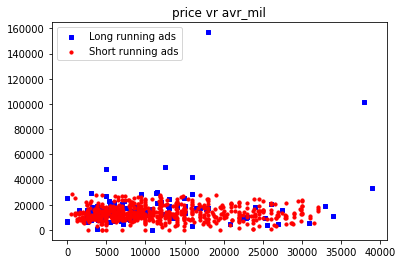

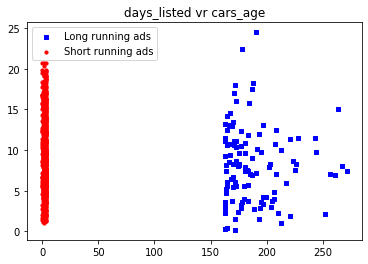

In [91]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(longs["price"], longs["avr_mil"], s=10, c='b', marker="s", label='Long running ads')
ax1.scatter(experimental["price"],experimental["avr_mil"], s=10, c='r', marker="o", label='Short running ads')
plt.title("price vr avr_mil")
plt.legend(loc='upper left');
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(longs["days_listed"], longs["cars_age"], s=10, c='b', marker="s", label='Long running ads')
ax1.scatter(experimental["days_listed"],experimental["cars_age"], s=10, c='r', marker="o", label='Short running ads')
plt.legend(loc='upper left');
plt.title("days_listed vr cars_age")
plt.show()

As we can see the relationship between price and avr_mil is similar and car's_age range is the same... 

Let's compare the two groups numerically.

In [92]:
print("LONGEST ADS")
for col in ["cars_age", "condition", "price", "avr_mil"]:
  print(col, ":", round(longs[col].median(), 2) )
print("")
# Let's compare it to the shortest ads group:
print("SHORTEST ADS")
for col in ["cars_age", "condition", "price", "avr_mil"]:
  print(col, ":", round(experimental[col].median(), 2) )

On median faster-selling cars are OLDER but have lower avr_mill. Their price is higher too!
But why these so called "fast" ads are so quick? 

Maybe the secret hides in the type of the car? 

Let's check!


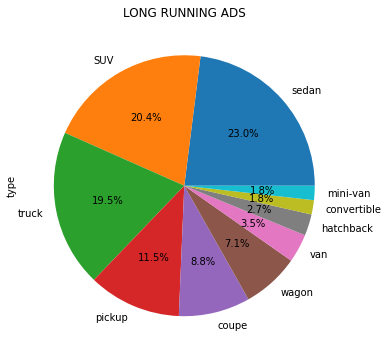

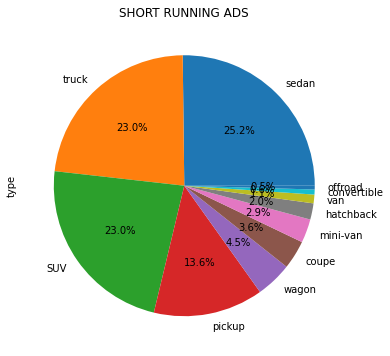

In [93]:

longs["type"].value_counts().plot.pie(y='type', figsize=(6, 6), autopct='%1.1f%%',title = "LONG RUNNING ADS")
plt.show()

experimental["type"].value_counts().plot.pie(y='type', figsize=(6, 6), autopct='%1.1f%%', title = "SHORT RUNNING ADS")
plt.show()

Sedan, SUV, truck and pickup are the most "popular" types in both lists... 

Let's create a loop that wil itterate through the parameters and return only the vallues that in overall % of the group are significantly large.  

We can compare the long adds to the raw_data, or short adds to the raw data, but we decided to compare short adds to long playing adds. Let's see the results!

In [94]:
list_of_parameters = ["condition", "is_4wd", "type", "paint_color", "transmission","fuel", "cylinders"]
column = []
val = []
row = []
for parameter in list_of_parameters:
  if ".dt.month" not in parameter:
    diff = experimental[parameter].value_counts(normalize=True)*100 - longs[parameter].value_counts(normalize=True)*100 
    for map in diff:
      if map >4 or map < -4:
        column.append(parameter)
        row.append(diff[diff.values ==map].index.values)
        val.append(round(map, 2))

diff = experimental.date_posted.dt.month.value_counts(normalize=True)*100 - longs.date_posted.dt.month.value_counts(normalize=True)*100
for map in diff:
       if map >4 or map < -4:
        column.append("posted month")
        row.append(diff[diff.values ==map].index.values)
        val.append(round(map, 2))

# Day of Week
diff = experimental.date_posted.dt.dayofweek.value_counts(normalize=True)*100 - longs.date_posted.dt.dayofweek.value_counts(normalize=True)*100 
for map in diff:
       if map >4 or map < -4:
        column.append("posted day of week")
        row.append(diff[diff.values ==map].index.values)
        val.append(round(map, 2))
# Year
diff = experimental.date_posted.dt.year.value_counts(normalize=True)*100 - longs.date_posted.dt.year.value_counts(normalize=True)*100 
for map in diff:
       if map >4 or map < -4:
        column.append("posted year")
        row.append(diff[diff.values ==map].index.values)
        val.append(round(map, 2))

# Model Year
diff = experimental.model_year.dt.year.value_counts(normalize=True)*100 - longs.model_year.dt.year.value_counts(normalize=True)*100 
for map in diff:
       if map >4 or map < -4:
        column.append("model year")
        row.append(diff[diff.values ==map].index.values)
        val.append(round(map, 2))

df = pd.DataFrame(list(zip(column, val, row)),columns =['Parameter', '%', "Criteria"])
print("The table bellow reprecents the difference between our clean set and the raw data in % ")
print(" ")
df.sort_values(by = "%")

We defined as a significant difference - any value that is bigger than 4 or smaller than -4 in % values of the overall sub-dataset, i.e. in the relationship to its group. 

Overall we found 10 such parameters: Paint of color is the most significant: the short playing ads had almost 8% less red cars, 5 % less cars  in "good" condition, and 5% more of the short ads were posted in 2018, the short ads group had almost 5 % more trucks and less 4.2% wagons, short ads group had 4% more cars with 8 cylinders.

Conclution of the analysis is that there's no single factor that shifted the instances between the two ad groups but a conbination of several factors. 

## Average price per each type of vehicle

Let's calculate the mean price per type:

In [95]:
# average price for each type of vehicle
avr_prc = cleanest.groupby(cleanest["type"])["price"].mean()
avr_prc.sort_values(ascending = False)


Number of ads for each type:

In [96]:
print(cleanest["type"].value_counts())

num_of_ads = cleanest["type"].value_counts()

Is there a correlation between the price and the number of ads per type? Let's create a corr_df and plot it:


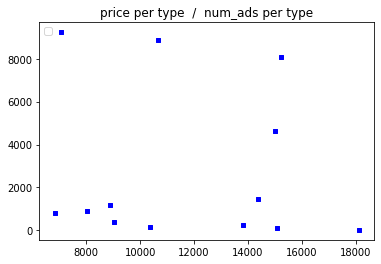

In [97]:
# Dependence of the number of ads on the avr price

corr_df = pd.DataFrame()
corr_df["avr_prc"] = round(avr_prc, 2)
corr_df["num_ads"] = cleanest.groupby(cleanest["type"])["type"].count()

print(corr_df)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(corr_df["avr_prc"] ,corr_df["num_ads"], s=10, c='b', marker="s")
plt.title("price per type  /  num_ads per type")
plt.legend(loc='upper left');
plt.show()




We do not notice a meaningfull correlation between the price and the number of ads per type. 

The three types with the greatest number of ads are sedan, truck and SUV.

> Indented block



## Price factors

In order to find out what impacts the price of our popular types: SUV, Sedan and Truck (let's use abbriviation SST) we will compare the SST parameters from the fast-to-sell group, against the SST from the slow-to-sell group. 

Our hypothesis is that the fast selling SST group will have the following parameters:


1.   Smaller age
2.   Smaller mileage
3.   Better condition
4.   Higher transmission
5.   Less "red" instances in color paint.

We are not interested in type of the cars, as we will treat the SST group as one big "favorite" type. We already know that these 3 types are the best sellers - as they top our fast selling list. 


The following function will take our SST cars as an input and then compare  "condition", "is_4wd", "paint_color", "transmission","fuel", "cylinders" from the fast selling ads against the slow selling ads and display the difference in % values. We are interested only in high % difference. > 8 or < -8

In [98]:
d = {}

def analizer(cars):
  for car in cars:
    d[car] = pd.DataFrame()
    list_of_parameters = ["condition", "is_4wd", "transmission", "cylinders"] # "paint_color", "fuel"
    column = []
    val = []
    row = []
    vehicle = [] 
    for parameter in list_of_parameters:

        # Here we compare 6 parameters:  "condition", "is_4wd", "paint_color", "transmission","fuel", "cylinders"
        diff = experimental[experimental["type"]== car][parameter].value_counts(normalize=True)*100 - longs[longs["type"]== car][parameter].value_counts(normalize=True)*100 
        for map in diff:
          if map >8 or map < -8:
            column.append(parameter)
            row.append(diff[diff.values ==map].index.values)
            val.append(round(map, 2))
            vehicle.append(car)

        # Here we compare only the month of posting
    diff = experimental[experimental["type"]== car].date_posted.dt.month.value_counts(normalize=True)*100 - longs[longs["type"]== car].date_posted.dt.month.value_counts(normalize=True)*100
    for map in diff:
          if map >8 or map < -8:
            column.append("posted month")
            row.append(diff[diff.values ==map].index.values)
            val.append(round(map, 2))
            vehicle.append(car)

        # Here we compare only the day of the week of posting
    diff = experimental[experimental["type"]== car].date_posted.dt.dayofweek.value_counts(normalize=True)*100 - longs[longs["type"]== car].date_posted.dt.dayofweek.value_counts(normalize=True)*100 
    for map in diff:
          if map >8 or map < -8:
            column.append("posted day of week")
            row.append(diff[diff.values ==map].index.values)
            val.append(round(map, 2))
            vehicle.append(car)

        # Here we compare only the year of posting
    diff = experimental[experimental["type"]== car].date_posted.dt.year.value_counts(normalize=True)*100 - longs[longs["type"]== car].date_posted.dt.year.value_counts(normalize=True)*100 
    for map in diff:
          if map >8 or map < -8:
            column.append("posted year")
            row.append(diff[diff.values ==map].index.values)
            val.append(round(map, 2))
            vehicle.append(car)

        # Here we compare only the model year of the car.
    diff = experimental[experimental["type"]==car].model_year.dt.year.value_counts(normalize=True)*100 - longs[longs["type"]== car].model_year.dt.year.value_counts(normalize=True)*100 
    for map in diff:
          if map >8 or map < -8:
            column.append("model year")
            row.append(diff[diff.values ==map].index.values)
            val.append(round(map, 2))
            vehicle.append(car)

    
      # Here we save all our calciulation in a seperate df for each car
    d[car] = pd.DataFrame(list(zip(column, val, row, vehicle)),columns =['Parameter', 'Value', "Criteria", "Vehicle"])


# Here we pass the list of our best selling vehicles
cars = ["SUV", "sedan", "truck"]

# And here we finnaly call the function. 
analizer(cars)

d


There are alot of TYPE SPECIFIC very significant distinctions but
is there any parameter that is COMMON to all SSTs? 

In [99]:
# A little house keeping to avoid error:

d["sedan"].Criteria = d["sedan"].Criteria.astype(int)
d["SUV"].Criteria = d["SUV"].Criteria.astype(int)
d["truck"].Criteria = d["truck"].Criteria.astype(int)

# Now let's merge the three dfs and see the overall picture:
result = pd.merge(d["sedan"], d["SUV"], on=["Parameter", "Criteria"])
result = pd.merge(result, d["truck"], on=["Parameter", "Criteria"])
result

Amazing! All the top selling vehicles share the same characteristics:
All three have on average 10% LESS cars in "good" condition (category 2 in condition) and 12% (on avr) MORE in "excellent" (category 3 in condition)!

Let's analize the color and fuel, will we find other common features among the three?

In [100]:
a = {}

def fuel_color_analizer(cars):
  for car in cars:
    a[car] = pd.DataFrame()
    list_of_parameters = [ "paint_color", "fuel"]
    val = []
    row = []
    vehicle = [] 
    for parameter in list_of_parameters:

        # Here we compare just 2 parameters: "paint_color" and "fuel".
        diff = experimental[experimental["type"]== car][parameter].value_counts(normalize=True)*100 - longs[longs["type"]== car][parameter].value_counts(normalize=True)*100 
        for map in diff:
          if map >8 or map < -8:
            column.append(parameter)
            row.append(diff[diff.values ==map].index.values)
            val.append(round(map, 2))
            vehicle.append(car)
    
      # Here we save all our calciulation in a seperate df for each car
    a[car] = pd.DataFrame(list(zip( row, val, vehicle)),columns =["Criteria", 'Value', "Type"])


# Here we pass the list of our best selling vehicles
cars = ["SUV", "sedan", "truck"]

# And here we finnaly call the function. 
fuel_color_analizer(cars)

for car in cars:
  print(a[car])
  print(" ")


No, there's no COMMON factor but there indeed very significant TYPE SPECIFIC factors that we found. Trucks that are red are doomed to sell slower, but white trucks sell faster, gas truck is not that popular among the fast buying people. They definetly prefer diesel. 

Let's sift our short running list on SST's best performing parameters: condition >= 3 and compare the medians with the long running ads.

In [101]:
new_df = experimental[experimental.condition >= 3]

print("LONGEST ADS")
for col in ["cars_age", "condition", "price", "avr_mil"]:
  print(col, ":", round(longs[col].median(), 2) )
print("")
# Let's compare it to the shortest ads group:
print("SHORTEST ADS, CONDITION>=3")
for col in ["cars_age", "condition", "price", "avr_mil"]:
  print(col, ":", round(new_df[col].median(), 2) )

We see that fast selling ads, on median, have a higher price, but a lower avr_mil. Suprisingly the condition in both groups remain on 3. Let's check the condition pies of these two groups:

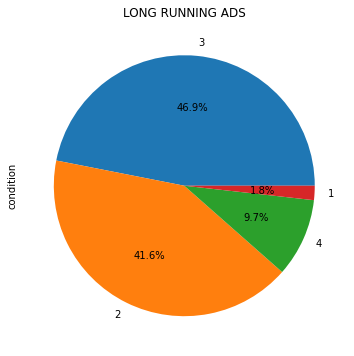

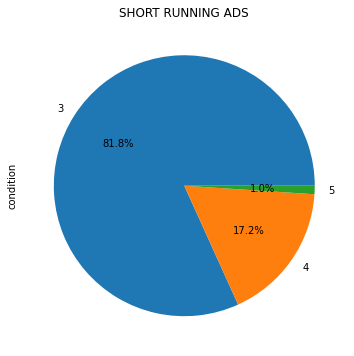

In [102]:
longs["condition"].value_counts().plot.pie(y='type', figsize=(6, 6), autopct='%1.1f%%',title = "LONG RUNNING ADS")
plt.show()

new_df["condition"].value_counts().plot.pie(y='type', figsize=(6, 6), autopct='%1.1f%%', title = "SHORT RUNNING ADS")
plt.show()

Here we see the problem of using median in our calculation. 
While are numeric comparison of a mean showed 3, it doesn't give us a real picture: condition = 3 in slow selling ads is only 45% and in fast selling ads  -  81.8%  

Finnaly let's plot a matrix of our fast selling SST

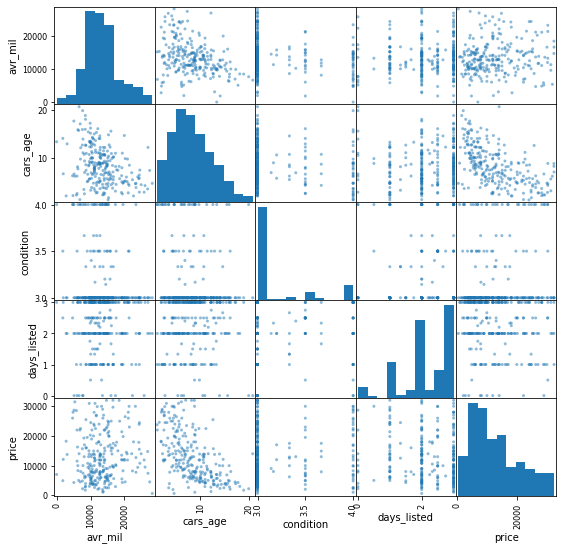

In [103]:
scat = new_df.pivot_table(index=new_df["price"], values=[ "price", "cars_age", 'avr_mil', 'condition', "days_listed"])


pd.plotting.scatter_matrix(scat, figsize=(9, 9))
plt.show()

In [104]:
# Let's check the correlation in numerics...

new_df.corr()

Let's also check transmission type and color!

First let's make sure that the transmission types and color paints have atleast 50 instances. 

In [105]:
new_df["paint_color"].value_counts()


Our colors are: *white, silver, grey*. All 3 have more than 50 instances. This will provide us a more stable EDA.

In [106]:
sub = new_df[new_df.paint_color.isin(["white", "grey", "silver"])]

#  let's check we did it right:
sub.paint_color.unique()


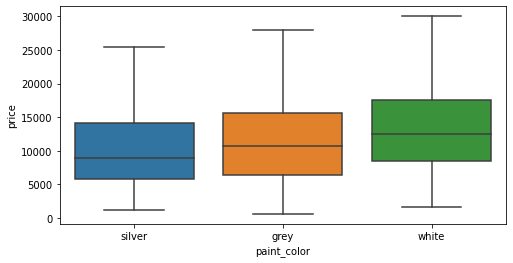

In [107]:
plt.figure(figsize = (8, 4 ))
ax = sns.boxplot(data = sub, x = "paint_color", y = "price", showfliers = False )

There's a slight preference of the white cars in our fast selling ads. It's Q2 lin is the highest among the three. 

Let's do the same for the transmission:

In [108]:
new_df["transmission"].value_counts()


Unfortunately we can't do this for the transmission as we have only a one type of transmission that meets our criteria (>50).



## General conclusion
We recieved a data of listings from a car's selling website. 
In order to perform EDA on the paramaters that influence the price of cars we performed the following:

1. We started by cleaning the raw data from the missing values, by asigning the values of identical instances in two columns where it was appropriate: model years and cylinder
2. We changed format to datetime in colums date of listing and model year. 
3. We filtered our data, getting rid of cars cheaper than 200$.
4. We've taken care of some very unusual high and low values.
5. We replaced the Nans with O in is_4wd as specified in the instructions. 
6. We enriched our data we new columns: avr_mil, cars age, yearly.
7. We changed the condition categories from str to numericals.
8. We also filtered our data by dropping the cars that were "antiques" - older than 40 y.o. sift.
9. Some house keeping was needed as brand new models with cars age == 0 caused problems in avr_mil calculation. Therefore we had to add 1 to all the years. 

In order to get rid of the outliers we decided to filter our data again, dropping the top 4% in our core numerical columns. 
By doing so we "pulled out" the medians. This allowed us to deal with the core of the data and not the dispersed version of it.
The price that we had to pay is that 29% of our data was lost.

The filtered data showed a very high correlation between the price and the parameters: cars_age, for example, had a -0.95 correlation and condition parameter showed 0.92 correlation.

Moving to analizing the ads lifetime we split our filtered data once again, choosing only the instances where the listing time was equal or below 3 days. The so called "fast selling ads". We then compared these instances against the very long selling ads and found, to our surprice, that, on the median, faster-selling cars are OLDER but have LOWER avr_mill while their price is higher! 
Overall we identified 10 sub-categories that had above 4% in the difference between the filtered data and the raw data. 
We didn't find any dependency between avr price and number of ads. 

The type of the dominant vehicles in these two groups were the same: SUV, Sedan and truck (SST)

We then calculated the difference between the parameters of the SST from the fast running ads and
the SST from the long runng ads and found out, again, 
that there are MULTIPLE TYPE SPECIFIC characteristics that were frequent in the fast selling ads.  
If there was one main factor that was dominant across all SST cars, a factor that diffrintiated the SSTs from fast running ads from SSTs from slow running ads is the CONDITION.
Fast running ads hade on avr above 12% more cars in 
condition *EXCELENT* and 10% less cars in condition *FAIR*. 

Coming back to our original task, the factors of price , we found that in our fast selling SSTs group the major factor is AVR_MIL (lower avr_mil cost more) and the color: White cars cost slightly more than grey and silver. 
